In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
from scipy.linalg import orth
from sklearn.metrics.pairwise import cosine_similarity as cosine
from sklearn.preprocessing import normalize
import seaborn as sns
from sklearn.decomposition import PCA
from terminaltables import AsciiTable as Table
from tqdm import tqdm_notebook as tqdm

In [23]:
def estimate_optimal_ncomponents(mat):
    pca = PCA()
    pca.fit(mat)
    opt = []
    total_var = 0
    nc = 0
    for var in pca.explained_variance_ratio_:
        total_var += var
        nc += 1
        if total_var >= 0.99:
            opt.append(nc)
            break
        elif total_var >= 0.95:
            opt.append(nc)
    return opt[0], opt[-1], len(pca.explained_variance_ratio_)

def pca_transform(mat):
    _, n, _ = estimate_optimal_ncomponents(mat)
    pca = PCA(n_components=n)
    return pca, pca.fit_transform(mat)

def cosine_sim(u, v):
    return 1-cosine(u, v)

# Train

In [3]:
import sys
sys.path.append('../src')

In [5]:
from common.utils import Struct
from data.loader import get_loader
from models.model_op import get_model_grads
from models.utils import get_model
import torch

In [42]:
args = {
    'input_size': 784,
    'output_size': 10,
    'clf': 'mlp',
    'no_cuda': False,
    'seed': 0,
    'device_id': [1],
    'lr': 1e-1, 
    'epochs': 50,
}
args = Struct(**args)

In [43]:
device = torch.device('cuda:1')
trainloader = get_loader('mnist', 60000, True)
model, _ = get_model(args)


optim = torch.optim.SGD(model.parameters(), lr=args.lr)
loss_fn = torch.nn.CrossEntropyLoss().to(device)

grads = []
for epoch in range(args.epochs):
    for i, data in enumerate(trainloader):
        X, Y = data[0].to(device), data[1].to(device)
        Y_ = model(X)
        loss = loss_fn(Y_, Y)
        optim.zero_grad()
        loss.backward()
        grads.append(get_model_grads(model))
        optim.step()
        print('[num_grads: {:3d}, NLL: {:.4f}]'.format(len(grads), loss.item()))

Initializing MLP...
# params: 1634530
# layers: 2.0
Loss: nll
[num_grads:   1, NLL: 2.3170]
[num_grads:   2, NLL: 1.8858]
[num_grads:   3, NLL: 1.5683]
[num_grads:   4, NLL: 1.3393]
[num_grads:   5, NLL: 1.1714]
[num_grads:   6, NLL: 1.0492]
[num_grads:   7, NLL: 0.9586]
[num_grads:   8, NLL: 0.8948]
[num_grads:   9, NLL: 0.8417]
[num_grads:  10, NLL: 0.8080]
[num_grads:  11, NLL: 0.7600]
[num_grads:  12, NLL: 0.7345]
[num_grads:  13, NLL: 0.6912]
[num_grads:  14, NLL: 0.6705]
[num_grads:  15, NLL: 0.6399]
[num_grads:  16, NLL: 0.6262]
[num_grads:  17, NLL: 0.6047]
[num_grads:  18, NLL: 0.5977]
[num_grads:  19, NLL: 0.5748]
[num_grads:  20, NLL: 0.5691]
[num_grads:  21, NLL: 0.5431]
[num_grads:  22, NLL: 0.5359]
[num_grads:  23, NLL: 0.5130]
[num_grads:  24, NLL: 0.5050]
[num_grads:  25, NLL: 0.4870]
[num_grads:  26, NLL: 0.4788]
[num_grads:  27, NLL: 0.4650]
[num_grads:  28, NLL: 0.4571]
[num_grads:  29, NLL: 0.4465]
[num_grads:  30, NLL: 0.4394]
[num_grads:  31, NLL: 0.4312]
[num_gra

In [11]:
model

DataParallel(
  (module): MLP(
    (fc1): Linear(in_features=784, out_features=2056, bias=True)
    (fc2): Linear(in_features=2056, out_features=10, bias=True)
    (relu): ReLU()
  )
)

In [19]:
components

[6, 5, 5, 3]

In [44]:
for p in model.parameters():
    print(p.shape)

torch.Size([2056, 784])
torch.Size([2056])
torch.Size([10, 2056])
torch.Size([10])


In [29]:
pcas[0].__dict__

{'n_components': 6,
 'copy': True,
 'whiten': False,
 'svd_solver': 'auto',
 'tol': 0.0,
 'iterated_power': 'auto',
 'random_state': None,
 '_fit_svd_solver': 'randomized',
 'mean_': array([ 6.1629621e-06, -5.4816883e-06,  8.4274870e-06,  4.5467923e-06,
         9.7993307e-06,  7.5522676e-06,  1.2678918e-05,  8.8913621e-06,
         1.4578783e-05,  9.0876301e-06,  1.3390457e-05,  8.3558934e-06,
         1.1577880e-05,  7.3758874e-06,  9.7134052e-06,  6.8814475e-06,
         8.5116917e-06,  6.8539116e-06,  7.8379035e-06,  6.9396406e-06,
         7.4171535e-06,  7.0169690e-06,  7.1319228e-06,  7.0329647e-06,
         6.9314187e-06,  6.9910379e-06,  6.7722294e-06,  6.8997506e-06,
         6.6211896e-06,  6.7557307e-06,  6.4708202e-06,  6.5809472e-06,
         6.3137709e-06,  6.3970733e-06,  6.1595092e-06,  6.2062663e-06,
         6.0076227e-06,  6.0246502e-06,  5.8643495e-06,  5.8544588e-06,
         5.7198995e-06,  5.6921672e-06,  5.5790233e-06,  5.5404103e-06,
         5.4480333e-06,  5

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


(1611904, 50) (1611904, 6) 6
(2056, 50) (2056, 5) 5
(20560, 50) (20560, 5) 5
(10, 50) (10, 4) 4


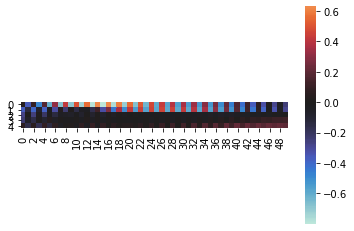

In [48]:
corr_mat = np.zeros((args.epochs, args.epochs))
num_layers = 0
components = []
pcas = []
ws = []
for layer_num in tqdm(range(len(grads[0])), leave=False):
    num_layers += 1
    accum = []
    for epoch_num in range(len(grads)):
        g = grads[epoch_num][layer_num]
        shape = g.shape
        accum.append(g.reshape(1, -1).cpu().numpy())
    stack_g = np.vstack(accum).T
    pca, pca_g = pca_transform(stack_g)
    components.append(pca_g.shape[1])
    pcas.append(pca)
    ws.append(pca_g)
    print(stack_g.shape, pca_g.shape, components[-1])
    pca_g = normalize(pca_g, axis=0)
#         stack_g, _ = np.linalg.qr(stack_g)
    stack_g = normalize(stack_g, axis=0)
    corr = np.matmul(pca_g.T, stack_g)
    corr_mat[:corr.shape[0], :corr.shape[1]] += corr 
sns.heatmap(corr_mat[:sum(components)//len(components)]/num_layers, center=0.0, square=True)
plt.show()

In [50]:
for idx, w in enumerate(ws):
    ws[idx] = w[:, 0]
    print(ws[idx].shape)

(1611904,)
(2056,)
(20560,)
(10,)


In [52]:
with torch.no_grad():
    for p, w in zip(model.parameters(), ws):
        p.copy_(p-args.lr*torch.Tensor(w).reshape(p.size()).to(device))

In [53]:
device = torch.device('cuda:1')
trainloader = get_loader('mnist', 60000, True)


optim = torch.optim.SGD(model.parameters(), lr=args.lr)
loss_fn = torch.nn.CrossEntropyLoss().to(device)

grads = []
for epoch in range(args.epochs):
    for i, data in enumerate(trainloader):
        X, Y = data[0].to(device), data[1].to(device)
        Y_ = model(X)
        loss = loss_fn(Y_, Y)
        optim.zero_grad()
        loss.backward()
        grads.append(get_model_grads(model))
        optim.step()
        print('[num_grads: {:3d}, NLL: {:.4f}]'.format(len(grads), loss.item()))

[num_grads:   1, NLL: 1.5720]
[num_grads:   2, NLL: 0.7157]
[num_grads:   3, NLL: 0.4135]
[num_grads:   4, NLL: 0.3706]
[num_grads:   5, NLL: 0.3644]
[num_grads:   6, NLL: 0.3609]
[num_grads:   7, NLL: 0.3577]
[num_grads:   8, NLL: 0.3548]
[num_grads:   9, NLL: 0.3520]
[num_grads:  10, NLL: 0.3494]
[num_grads:  11, NLL: 0.3469]
[num_grads:  12, NLL: 0.3444]
[num_grads:  13, NLL: 0.3421]
[num_grads:  14, NLL: 0.3398]
[num_grads:  15, NLL: 0.3377]
[num_grads:  16, NLL: 0.3356]
[num_grads:  17, NLL: 0.3336]
[num_grads:  18, NLL: 0.3316]
[num_grads:  19, NLL: 0.3297]
[num_grads:  20, NLL: 0.3278]
[num_grads:  21, NLL: 0.3260]
[num_grads:  22, NLL: 0.3243]
[num_grads:  23, NLL: 0.3226]
[num_grads:  24, NLL: 0.3209]
[num_grads:  25, NLL: 0.3193]
[num_grads:  26, NLL: 0.3178]
[num_grads:  27, NLL: 0.3162]
[num_grads:  28, NLL: 0.3147]
[num_grads:  29, NLL: 0.3132]
[num_grads:  30, NLL: 0.3118]
[num_grads:  31, NLL: 0.3104]
[num_grads:  32, NLL: 0.3090]
[num_grads:  33, NLL: 0.3077]
[num_grads